## Import Libraries

In [32]:
import pandas as pd
import nltk as lp
import streamlit as st
import seaborn as sns

## Data processing

### Load in data

In [152]:
df = pd.read_csv("expenses.csv", sep=',', parse_dates=['date'], names=['date','account_name','from_acc_num','to_acc_num','code','af_bij','amount_(eur)','type','description'], header=0)

### Convert EUR (str) into float datatype (only need to do it once)

In [153]:
df['amount_(eur)'] = [float(i.replace(',','.')) for i in df['amount_(eur)']]
df.head()

,date,account_name,from_acc_num,to_acc_num,code,af_bij,amount_(eur),type,description
0,2022-10-06,CBR via ING,NL58INGB0658210033,NL92INGB0005302809,ID,Af,42.50,iDEAL,Naam: CBR via ING Omschrijving: 4595739362 005...
1,2022-10-06,Hr ZY Lian,NL58INGB0658210033,NaN,GT,Bij,100.00,Online bankieren,Van Oranje spaarrekening Z54728857 Valutadatum...
2,2022-10-06,Sports Supplements Ltd,NL58INGB0658210033,NL04ADYB2017400157,ID,Af,48.53,iDEAL,Naam: Sports Supplements Ltd Omschrijving: R8K...
3,2022-10-06,Mw E Guerrero Mavrou,NL58INGB0658210033,NL40INGB0657361607,GT,Af,18.00,Online bankieren,Naam: Mw E Guerrero Mavrou Omschrijving: Stora...
4,2022-10-06,Jumbo Overwinningspl GRONINGEN,NL58INGB0658210033,NaN,BA,Af,45.67,Betaalautomaat,Pasvolgnr: 900 05-10-2022 18:41 Transactie: W7...


#### Filtering for simple overview of all payments made for tuition

In [154]:
df_tuition = df[(df['af_bij'] == 'Af') 
                & (df['amount_(eur)'] >= 2000) 
                & (df['account_name'] != 'Hr ZY Lian')][['date','account_name', 'amount_(eur)']]

##### Lineplot

<AxesSubplot:xlabel='date'>

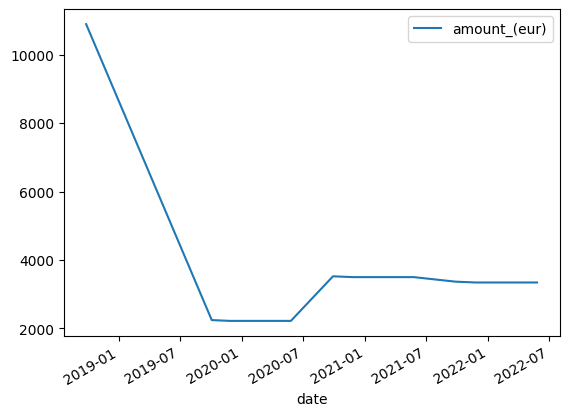

In [155]:
df_tuition.plot(x='date', y='amount_(eur)', kind='line')

##### Boxplot

amount_(eur)    AxesSubplot(0.125,0.53;0.352273x0.35)
dtype: object

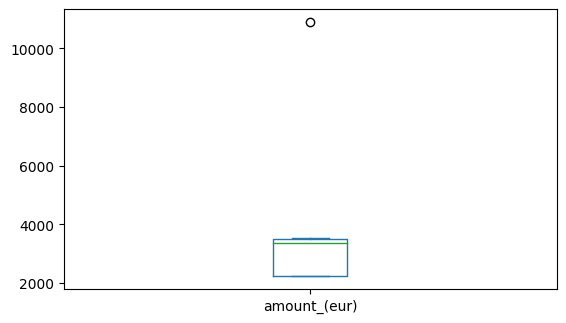

In [156]:
df_tuition['amount_(eur)'].plot(kind='box', vert=True, subplots=True, layout=(2,2), figsize=(14,8))

##### Density plot

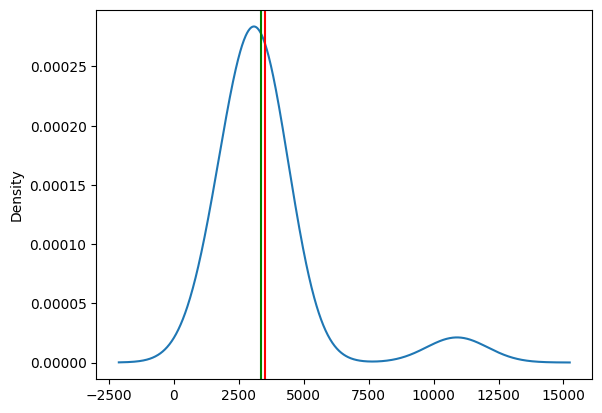

In [157]:
ax = df_tuition['amount_(eur)'].plot(kind='density')
ax.axvline(df_tuition['amount_(eur)'].mean(), color='red')
ax.axvline(df_tuition['amount_(eur)'].median(), color='green')

##### Histogram

<AxesSubplot:ylabel='Frequency'>

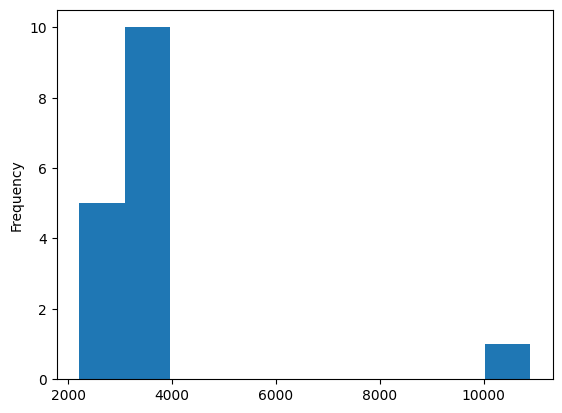

In [158]:
df_tuition['amount_(eur)'].plot(kind='hist')

### General DataFrame info

In [159]:
df.shape

(5958, 9)

In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5958 entries, 0 to 5957
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          5958 non-null   datetime64[ns]
 1   account_name  5958 non-null   object        
 2   from_acc_num  5958 non-null   object        
 3   to_acc_num    2255 non-null   object        
 4   code          5958 non-null   object        
 5   af_bij        5958 non-null   object        
 6   amount_(eur)  5958 non-null   float64       
 7   type          5958 non-null   object        
 8   description   5958 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 419.0+ KB


In [161]:
df.describe()

,amount_(eur)
count,5958.000000
mean,102.539260
std,412.786305
min,0.010000
25%,5.000000
50%,13.245000
75%,43.362500
max,10900.000000


In [163]:
df.loc[:,['to_acc_num']].value_counts()

to_acc_num            
NL50INGB0654704694        253
NL31INGB0654704066        211
NL55INGB0001979576        107
DE88500700100175526303     95
NL24INGB0655502599         83
                         ... 
NL30ABNA0524590958          1
NL29DEUT0319800040          1
NL21RABO0301998604          1
NL21ABNA0443441987          1
NL98RABO0116746424          1
Length: 195, dtype: int64

In [164]:
df[(df['to_acc_num'] == 'NL50INGB0654704694') | (df['to_acc_num'] == 'NL31INGB0654704066') & (df['description'])]

,date,account_name,from_acc_num,to_acc_num,code,af_bij,amount_(eur),type,description
62,2022-09-11,Hr G Donadon,NL58INGB0658210033,NL31INGB0654704066,GT,Bij,64.32,Online bankieren,Naam: Hr G Donadon IBAN: NL31INGB0654704066 Da...
146,2022-08-26,Massimiliano Donadon,NL58INGB0658210033,NL50INGB0654704694,GT,Af,500.00,Online bankieren,Naam: Massimiliano Donadon Omschrijving: Bo-Re...
252,2022-07-22,Hr M Donadon,NL58INGB0658210033,NL50INGB0654704694,GT,Bij,54.14,Online bankieren,Naam: Hr M Donadon Omschrijving: Noordelijk Be...
331,2022-06-27,Hr M Donadon,NL58INGB0658210033,NL50INGB0654704694,GT,Bij,3.15,Online bankieren,Naam: Hr M Donadon Omschrijving: Kuss gift IBA...
385,2022-06-10,Massimiliano Donadon,NL58INGB0658210033,NL50INGB0654704694,GT,Af,2.00,Online bankieren,Naam: Massimiliano Donadon IBAN: NL50INGB06547...
...,...,...,...,...,...,...,...,...,...
5552,2018-03-05,Hr G Donadon,NL58INGB0658210033,NL31INGB0654704066,GT,Bij,6.00,Online bankieren,Naam: Hr G Donadon IBAN: NL31INGB0654704066 Va...
5553,2018-03-05,Hr M Donadon,NL58INGB0658210033,NL50INGB0654704694,GT,Bij,6.00,Online bankieren,Naam: Hr M Donadon IBAN: NL50INGB0654704694 Va...
5611,2018-02-19,Hr G Donadon,NL58INGB0658210033,NL31INGB0654704066,GT,Bij,11.50,Online bankieren,Naam: Hr G Donadon Omschrijving: Movie IBAN: N...
5612,2018-02-19,Hr M Donadon,NL58INGB0658210033,NL50INGB0654704694,GT,Bij,11.50,Online bankieren,Naam: Hr M Donadon Omschrijving: Movie IBAN: N...


### Convert text to numbers